<a name='1'></a>
# **1. Import Required Packages**

### **1.1. Import Custom Packages**

In [1]:
############################################################################
# Mount Google Drive to /content/drive' and set default module path
############################################################################
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
############################################################################
# Set default module path
############################################################################
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/aerial-image-segmentation-with-unet/modules')

In [3]:
############################################################################
# Import custom packages
############################################################################
# Data loading and preprocessing functions
from tf_keras_image_segmentation_models.preprocessing import list_image_paths
from tf_keras_image_segmentation_models.preprocessing import data_generator
from tf_keras_image_segmentation_models.preprocessing import display

# Model function
from tf_keras_image_segmentation_models.models.unet import unet

# Evaluation metrics functions
from tf_keras_image_segmentation_models.metrics import IoU
from tf_keras_image_segmentation_models.metrics import classification_report
from tf_keras_image_segmentation_models.predict import predict_mask
from tf_keras_image_segmentation_models.predict import show_predictions

### **1.2. Import Other Packages**

In [4]:
import numpy as np
import imageio
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

<a name='2'></a>
# **2. Load and Preprocess Dataset**

The Aeroscape dataset consists of 3269 images and their segmenatation labels (masks). As part of the data preparation step, we will load images and masks from all the five directories and carry out the a few preprocessing steps to ensure we provide our model with quality dataset.

<a name='2-1'></a>
### **2.1. Load the images and masks from their directories**

In [5]:
dataset_directory = '/content/drive/My Drive/Colab Notebooks/aerial-image-segmentation-with-unet/dataset/aeroscapes/'
image_directory_path = dataset_directory + 'JPEGImages'
mask_directory_path = dataset_directory + 'SegmentationClass'

In [6]:
# Use the 'list_image_paths' function to extract image and segmentation filepaths 
# from their directories
image_paths, mask_paths = list_image_paths(image_directory_path, mask_directory_path) 
number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[1]}")
print(f"3. An example of a mask path is: \n {mask_paths[1]}")


1. There are 3269 images and 3269 masks in our dataset
2. An example of an image path is: 
 /content/drive/My Drive/Colab Notebooks/aerial-image-segmentation-with-unet/dataset/aeroscapes/JPEGImages/000001_071.jpg
3. An example of a mask path is: 
 /content/drive/My Drive/Colab Notebooks/aerial-image-segmentation-with-unet/dataset/aeroscapes/SegmentationClass/000001_071.png


<a name='2-2'></a>
### **2.2. Split the image and mask paths into training, validation, and test sets**

In [7]:
# First split the image paths into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.8, random_state=42)

# Keep part of the validation set as test set
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size = 0.60, random_state=42)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')
print(f'There are {len(test_image_paths)} images in the Test Set')

There are 2615 images in the Training Set
There are 392 images in the Validation Set
There are 262 images in the Test Set


<a name='2-3'></a>
### **2.3. - Create data generation pipelines to read and preprocess our data**

We will be using the tf.data.Dataset API to load our images and masks for our model to process. The Dataset API allows us to build an asynchronous, highly optimized data pipeline to prevent our GPU from data starvation. It loads data from the disk (images or text), applies optimized transformations, creates batches and sends it to the GPU. Unlike former data pipelines made the GPU, the Dataset API wait for the CPU to load the data, leading to performance issues.

To do this, we will be using a pre-defined 'data_generator' function.

In [8]:
# Define Data Generation Variables 
batch_size = 32
buffer_size = 5120
image_size = (128,128)
image_channels =3
cache_dataset = True
shuffle_dataset = True
augment=True 
augment_type="horizontal_and_vertical"

# Create Data Generator Pipelines
train_dataset = data_generator(train_image_paths, train_mask_paths, 
                               image_size=image_size, image_channels=image_channels, 
                               batch_size=batch_size, cache_dataset=cache_dataset, 
                               shuffle_dataset=shuffle_dataset, buffer_size=buffer_size,
                               augment=augment, augment_type=augment_type)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, 
                               image_size=image_size, image_channels=image_channels, 
                               batch_size=batch_size, cache_dataset=cache_dataset, 
                               shuffle_dataset=shuffle_dataset, buffer_size=buffer_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, 
                               image_size=image_size, image_channels=image_channels, 
                               batch_size=batch_size, cache_dataset=cache_dataset, 
                               shuffle_dataset=shuffle_dataset, buffer_size=buffer_size)


#### **2.2.4. Preview sample images and masks from the three dataset categories**

<a name='3'></a>
# **3. Model Architecture, Training, Evaluation and Prediction**

## **3.1. Model Architecture and Training**

In [9]:
model = unet(num_classes=12,
         encoder_type='DenseNet121',
         input_shape=(128, 128, 3),
         model_weights=None,
         num_blocks=5,
         encoder_weights='imagenet',
         encoder_freeze=False,
         encoder_filters=[32, 64, 128, 256, 512],
         decoder_type='transpose',
         num_decoder_block_conv_layers=1,
         decoder_activation='relu',
         decoder_use_skip_connection=True,
         decoder_use_batchnorm=True,
         decoder_dropout_rate=0,
         output_activation='softmax')

#model.summary()

29097984/29084464 [==============================] - 0s 0us/step


In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=10, verbose=1, min_lr = 2e-6)
batch_size = 64
epochs = 50

In [11]:
history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [reduce_lr], 
                    batch_size = batch_size,
                    shuffle = True)

Epoch 1/50
82/82 [==============================] - 869s 2s/step - loss: 0.9073 - accuracy: 0.7006 - val_loss: 4.7344 - val_accuracy: 0.3405 - lr: 0.0010
Epoch 2/50
82/82 [==============================] - 49s 597ms/step - loss: 0.4645 - accuracy: 0.8433 - val_loss: 2.4580 - val_accuracy: 0.4336 - lr: 0.0010
Epoch 3/50
82/82 [==============================] - 49s 597ms/step - loss: 0.3874 - accuracy: 0.8709 - val_loss: 1.6156 - val_accuracy: 0.5493 - lr: 0.0010
Epoch 4/50
82/82 [==============================] - 49s 597ms/step - loss: 0.3126 - accuracy: 0.8960 - val_loss: 1.6187 - val_accuracy: 0.5447 - lr: 0.0010
Epoch 5/50
82/82 [==============================] - 49s 597ms/step - loss: 0.3009 - accuracy: 0.8995 - val_loss: 0.5078 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 6/50
82/82 [==============================] - 49s 595ms/step - loss: 0.2495 - accuracy: 0.9172 - val_loss: 0.3575 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 7/50
82/82 [==============================] - 49s 597ms/step

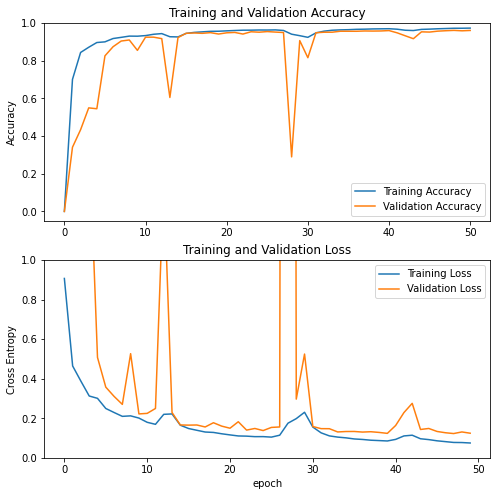

In [12]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **3.2 Model Evaluation**


In [13]:
true_train_masks, predicted_train_masks = predict_mask(train_dataset, model)
true_validation_masks, predicted_validation_masks = predict_mask(validation_dataset, model)
true_test_masks, predicted_test_masks = predict_mask(test_dataset, model)

In [14]:
target_names = ['Background', 'Person', 'Bike', 'Car', 'Drone', 'Boat', 'Animal', 'Obstacle', 'Construction', 'Vegetation', 'Road', 'Sky']
train_report = classification_report(true_train_masks, 
                                     predicted_train_masks, 
                                     num_classes=12,
                                     metrics=["TP", "TN", "FP", "FN", "Recall", "Precision", "Sensitivity", "Specificity", "IoU", "TDR", "F1Score"], 
                                     target_names=target_names, 
                                     report_type = 'table', 
                                     table_type='tabulate-table', 
                                     show_mean_evaluations=True,
                                     show_classwise_evaluations=True)

train_report

╒══════════════╤══════════╤═══════════╤═════════╤═════════╤══════════╤═════════════╤═══════════════╤═══════════════╤═══════╤═══════╤═══════════╕
│ Evaluation   │ TP       │ TN        │ FP      │ FN      │   Recall │   Precision │   Sensitivity │   Specificity │   IoU │   TDR │   F1Score │
╞══════════════╪══════════╪═══════════╪═════════╪═════════╪══════════╪═════════════╪═══════════════╪═══════════════╪═══════╪═══════╪═══════════╡
│ Overall      │ 41707366 │ 470148966 │ 1136794 │ 1136794 │     0.97 │        0.97 │          0.08 │          1    │  0.95 │  0.08 │      0.97 │
├──────────────┼──────────┼───────────┼─────────┼─────────┼──────────┼─────────────┼───────────────┼───────────────┼───────┼───────┼───────────┤
│ Mean         │ -        │ -         │ -       │ -       │     0.82 │        0.87 │          0.08 │          1    │  0.75 │  0.08 │      0.84 │
├──────────────┼──────────┼───────────┼─────────┼─────────┼──────────┼─────────────┼───────────────┼───────────────┼───────┼──────

In [15]:
validation_report = classification_report(true_validation_masks, 
                                          predicted_validation_masks, 
                                          num_classes=12,
                                          metrics=["TP", "TN", "FP", "FN", "Recall", "Precision", "Sensitivity", "Specificity", "IoU", "TDR", "F1Score"],
                                          target_names=target_names,
                                          report_type = 'table', 
                                          table_type='tabulate-table',
                                          show_mean_evaluations=True,
                                          show_classwise_evaluations=True)

validation_report



╒══════════════╤═════════╤══════════╤════════╤════════╤══════════╤═════════════╤═══════════════╤═══════════════╤═══════╤═══════╤═══════════╕
│ Evaluation   │ TP      │ TN       │ FP     │ FN     │   Recall │   Precision │   Sensitivity │   Specificity │   IoU │   TDR │   F1Score │
╞══════════════╪═════════╪══════════╪════════╪════════╪══════════╪═════════════╪═══════════════╪═══════════════╪═══════╪═══════╪═══════════╡
│ Overall      │ 6165856 │ 70391136 │ 256672 │ 256672 │     0.96 │        0.96 │          0.08 │          1    │  0.92 │  0.08 │      0.96 │
├──────────────┼─────────┼──────────┼────────┼────────┼──────────┼─────────────┼───────────────┼───────────────┼───────┼───────┼───────────┤
│ Mean         │ -       │ -        │ -      │ -      │     0.71 │        0.81 │          0.08 │          1    │  0.64 │  0.08 │      0.75 │
├──────────────┼─────────┼──────────┼────────┼────────┼──────────┼─────────────┼───────────────┼───────────────┼───────┼───────┼───────────┤
│ Background 

In [16]:
test_report = classification_report(true_test_masks, 
                                    predicted_test_masks, 
                                    num_classes=12,
                                    metrics=["TP", "TN", "FP", "FN", "Recall", "Precision", "Sensitivity", "Specificity", "IoU", "TDR", "F1Score"],
                                    target_names=target_names, 
                                    report_type = 'table', 
                                    table_type='tabulate-table', 
                                    show_mean_evaluations=True,
                                    show_classwise_evaluations=True)

test_report

╒══════════════╤═════════╤══════════╤════════╤════════╤══════════╤═════════════╤═══════════════╤═══════════════╤═══════╤═══════╤═══════════╕
│ Evaluation   │ TP      │ TN       │ FP     │ FN     │   Recall │   Precision │   Sensitivity │   Specificity │   IoU │   TDR │   F1Score │
╞══════════════╪═════════╪══════════╪════════╪════════╪══════════╪═════════════╪═══════════════╪═══════════════╪═══════╪═══════╪═══════════╡
│ Overall      │ 4105134 │ 47031214 │ 187474 │ 187474 │     0.96 │        0.96 │          0.08 │          1    │  0.92 │  0.08 │      0.96 │
├──────────────┼─────────┼──────────┼────────┼────────┼──────────┼─────────────┼───────────────┼───────────────┼───────┼───────┼───────────┤
│ Mean         │ -       │ -        │ -      │ -      │     0.71 │        0.8  │          0.08 │          1    │  0.64 │  0.08 │      0.75 │
├──────────────┼─────────┼──────────┼────────┼────────┼──────────┼─────────────┼───────────────┼───────────────┼───────┼───────┼───────────┤
│ Background 

## **3.3. Predict image segmentations using the trained Model**

#### **3.3.1. Predict and compare masks of images in the training set**

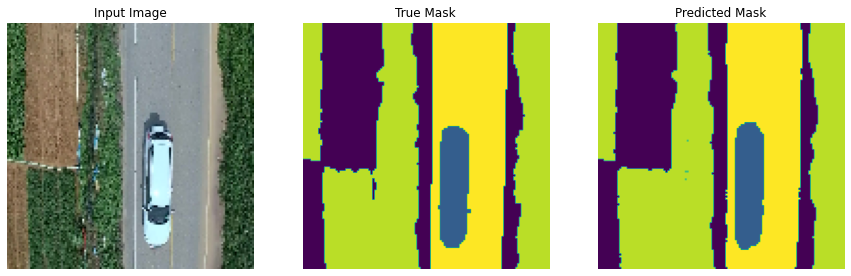

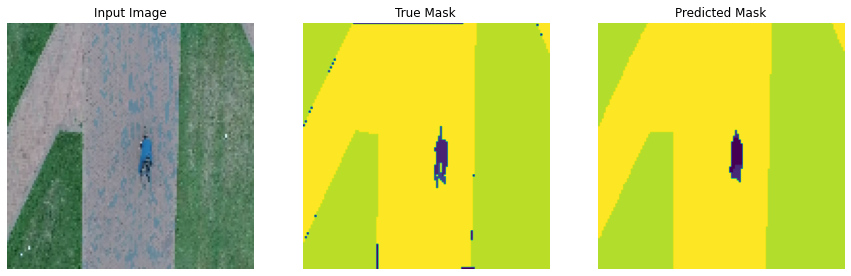

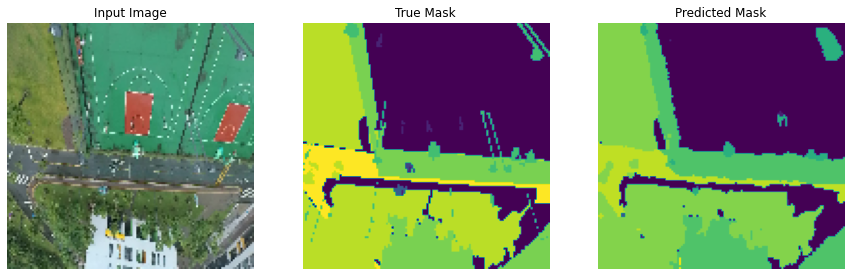

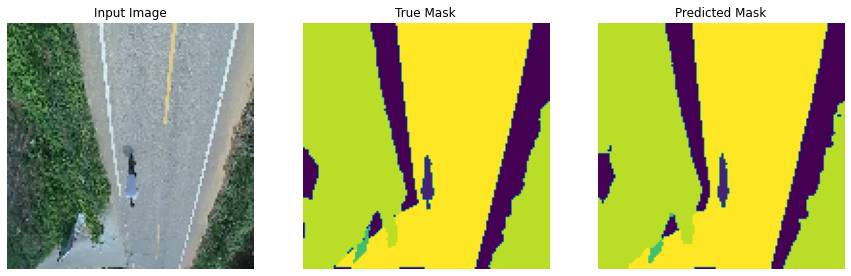

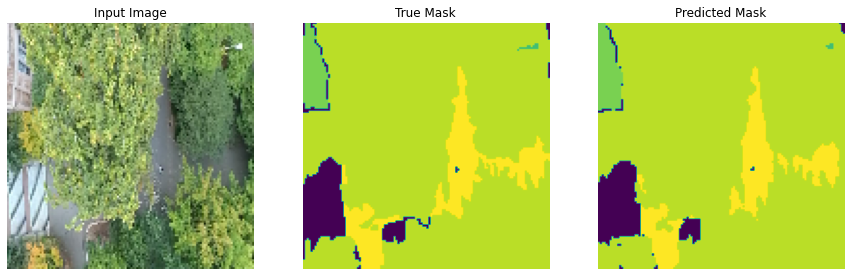

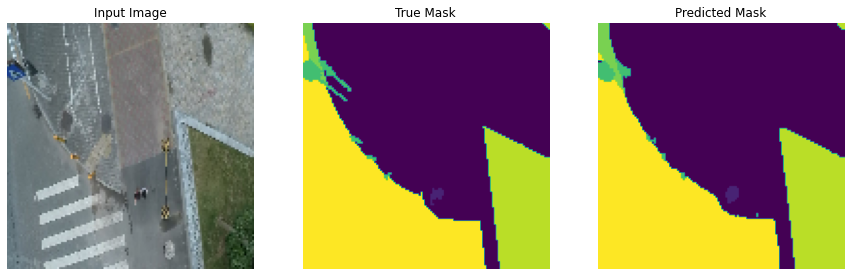

In [17]:
show_predictions(train_dataset, model, num_batches=6, num_per_batch=1, random_state=True)

#### **3.3.2. Predict and compare masks of images in the validation set**

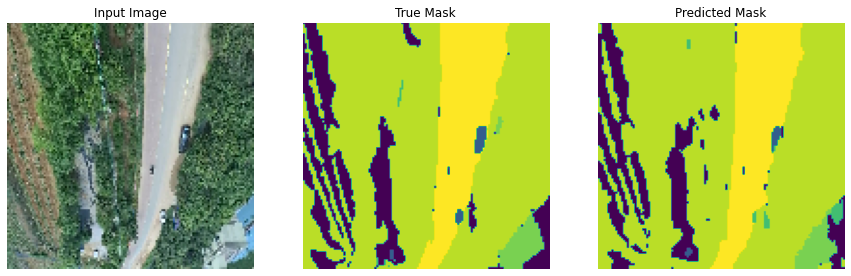

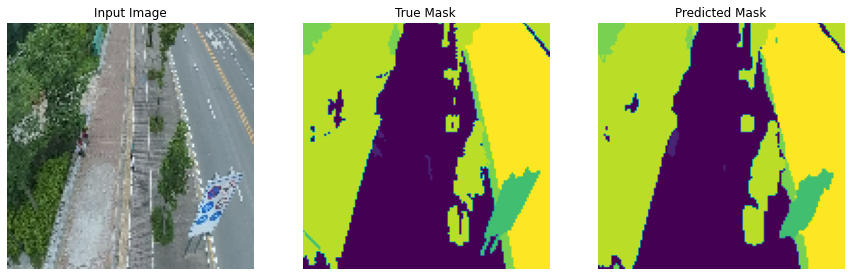

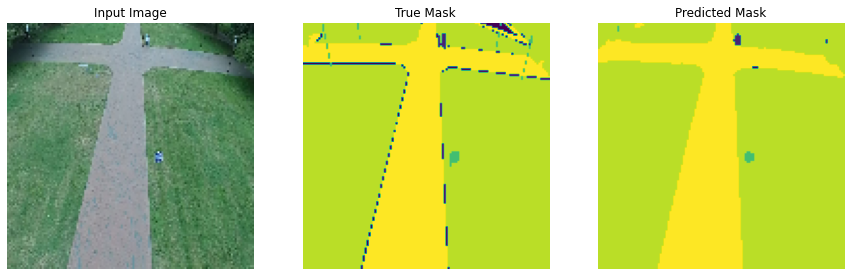

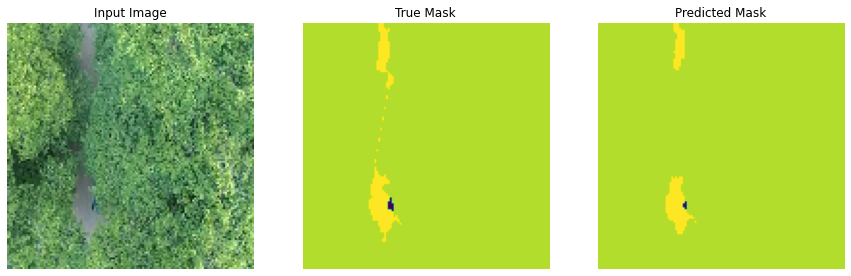

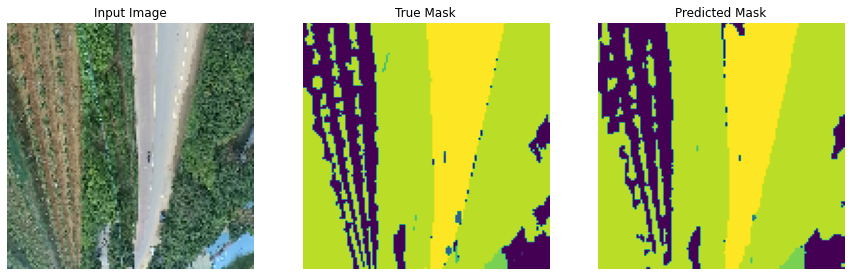

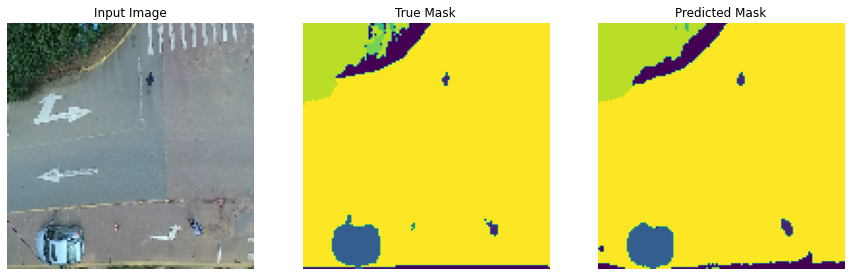

In [18]:
show_predictions(validation_dataset, model, num_batches=6, num_per_batch=1, random_state=True)

#### **3.3.3. Predict and compare masks of images in the test set**

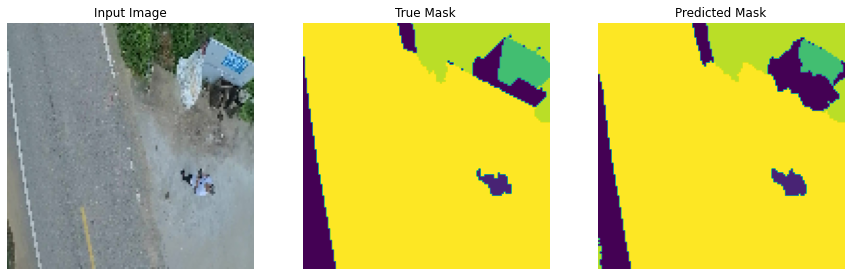

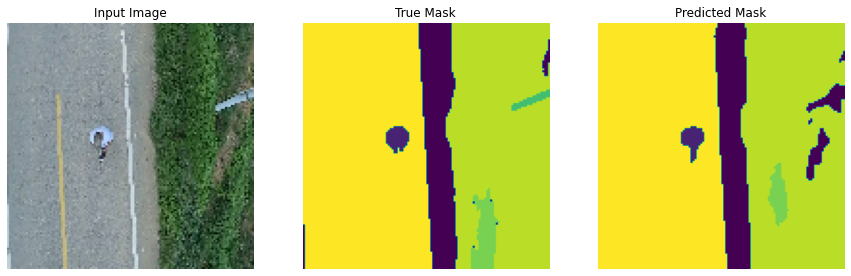

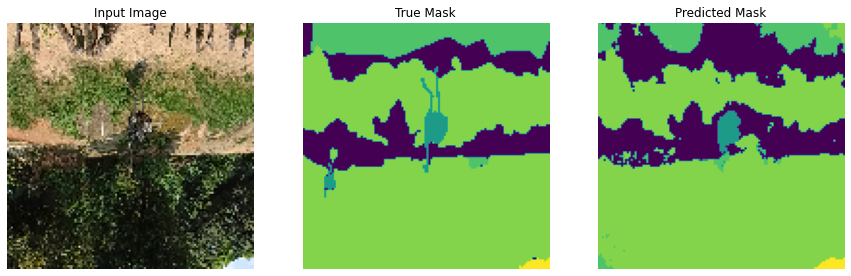

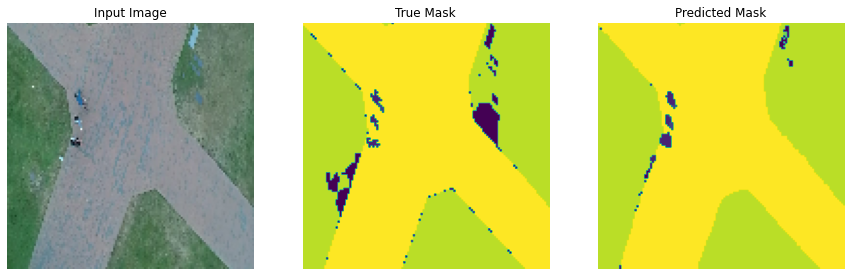

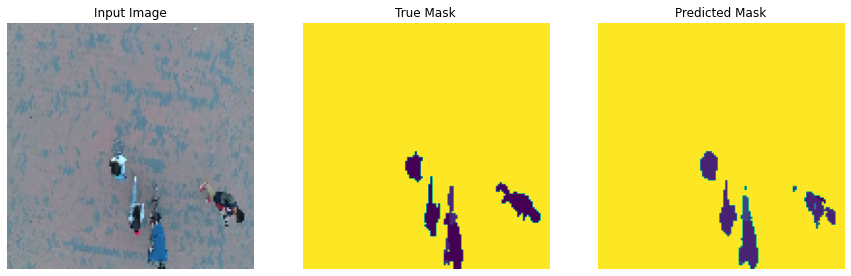

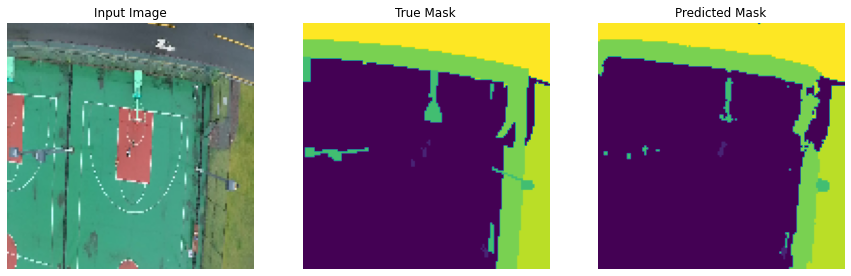

In [19]:
show_predictions(test_dataset, model, num_batches=6, num_per_batch=1, random_state=True)